In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [80]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

pass_A2 = pass_A2[pass_A2['肇因研判大類別名稱-主要'] != '駕駛者']
pass_A1 = pass_A1[pass_A1['肇因研判大類別名稱-主要'] != '駕駛者']
pass_A2 = pass_A2[pass_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
pass_A1 = pass_A1[pass_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (3015, 129)


In [78]:
pass_A1['肇因研判大類別名稱-主要'].value_counts()

肇因研判大類別名稱-主要
非駕駛者           56
其他              1
無(非車輛駕駛人因素)     1
Name: count, dtype: int64

篩選掉未紀錄資料以及分類人的狀態以及車的狀態

由於人的狀態資料量已經很少，所以不進行下採樣

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.237         7.02%                      7.02%
1              0.117         3.46%                     10.49%
2              0.110         3.27%                     13.75%
3              0.083         2.44%                     16.20%
4              0.077         2.28%                     18.48%
5              0.072         2.13%                     20.61%
6              0.068         2.01%                     22.62%
7              0.063         1.87%                     24.50%
8              0.055         1.62%                     26.11%
9              0.051         1.52%                     27.64%
10             0.050         1.48%                     29.12%


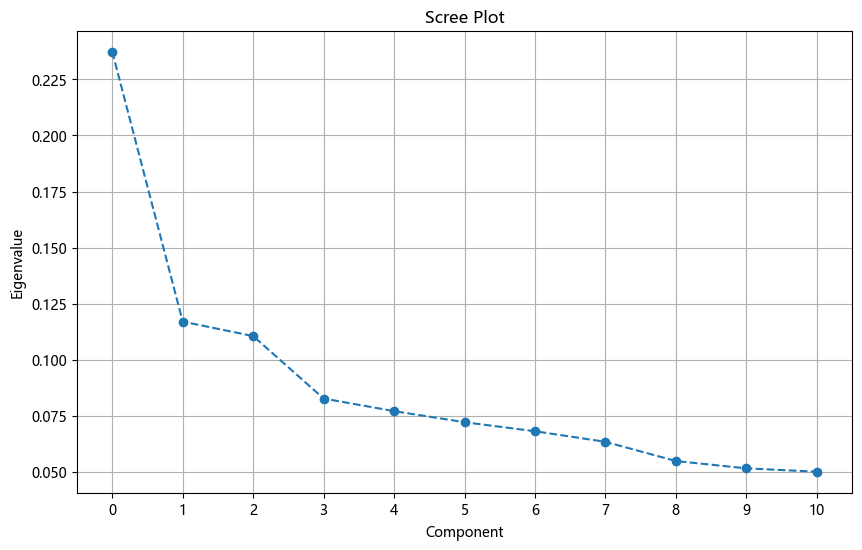

In [81]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=11,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [86]:
import pickle

detailed_results = []

for overlap in range(1, 6):
    silhouette_for_intervals = []

    for interval in range(2, 11):
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 1, interval: 2


Processing Clusters: 100%|██████████| 14/14 [00:00<00:00, 53.55it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i2.pkl
overlap: 1, interval: 3


Processing Clusters: 100%|██████████| 46/46 [00:00<00:00, 189.72it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i3.pkl
overlap: 1, interval: 4


Processing Clusters: 100%|██████████| 58/58 [00:00<00:00, 277.31it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i4.pkl
overlap: 1, interval: 5


Processing Clusters: 100%|██████████| 141/141 [00:00<00:00, 736.26it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i5.pkl
overlap: 1, interval: 6


Processing Clusters: 100%|██████████| 128/128 [00:00<00:00, 922.55it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i6.pkl
overlap: 1, interval: 7


Processing Clusters: 100%|██████████| 147/147 [00:00<00:00, 830.58it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i7.pkl
overlap: 1, interval: 8


Processing Clusters: 100%|██████████| 199/199 [00:00<00:00, 1272.16it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i8.pkl
overlap: 1, interval: 9


Processing Clusters: 100%|██████████| 233/233 [00:00<00:00, 1422.88it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i9.pkl
overlap: 1, interval: 10


Processing Clusters: 100%|██████████| 297/297 [00:00<00:00, 1972.71it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o1i10.pkl
overlap: 2, interval: 2


Processing Clusters: 100%|██████████| 10/10 [00:00<00:00, 33.52it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i2.pkl
overlap: 2, interval: 3


Processing Clusters: 100%|██████████| 37/37 [00:00<00:00, 66.66it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i3.pkl
overlap: 2, interval: 4


Processing Clusters: 100%|██████████| 44/44 [00:00<00:00, 141.71it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i4.pkl
overlap: 2, interval: 5


Processing Clusters: 100%|██████████| 100/100 [00:00<00:00, 185.20it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i5.pkl
overlap: 2, interval: 6


Processing Clusters: 100%|██████████| 101/101 [00:00<00:00, 494.97it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i6.pkl
overlap: 2, interval: 7


Processing Clusters: 100%|██████████| 103/103 [00:00<00:00, 332.78it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i7.pkl
overlap: 2, interval: 8


Processing Clusters: 100%|██████████| 141/141 [00:00<00:00, 392.56it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i8.pkl
overlap: 2, interval: 9


Processing Clusters: 100%|██████████| 176/176 [00:00<00:00, 786.57it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i9.pkl
overlap: 2, interval: 10


Processing Clusters: 100%|██████████| 218/218 [00:00<00:00, 809.85it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o2i10.pkl
overlap: 3, interval: 2


Processing Clusters: 100%|██████████| 10/10 [00:00<00:00, 29.93it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i2.pkl
overlap: 3, interval: 3


Processing Clusters: 100%|██████████| 27/27 [00:00<00:00, 33.00it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i3.pkl
overlap: 3, interval: 4


Processing Clusters: 100%|██████████| 34/34 [00:00<00:00, 58.15it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i4.pkl
overlap: 3, interval: 5


Processing Clusters: 100%|██████████| 58/58 [00:00<00:00, 77.67it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i5.pkl
overlap: 3, interval: 6


Processing Clusters: 100%|██████████| 71/71 [00:00<00:00, 118.99it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i6.pkl
overlap: 3, interval: 7


Processing Clusters: 100%|██████████| 81/81 [00:00<00:00, 227.26it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i7.pkl
overlap: 3, interval: 8


Processing Clusters: 100%|██████████| 100/100 [00:00<00:00, 185.51it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i8.pkl
overlap: 3, interval: 9


Processing Clusters: 100%|██████████| 125/125 [00:00<00:00, 337.07it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i9.pkl
overlap: 3, interval: 10


Processing Clusters: 100%|██████████| 168/168 [00:00<00:00, 308.85it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o3i10.pkl
overlap: 4, interval: 2


Processing Clusters: 100%|██████████| 11/11 [00:00<00:00, 14.09it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i2.pkl
overlap: 4, interval: 3


Processing Clusters: 100%|██████████| 21/21 [00:00<00:00, 24.93it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i3.pkl
overlap: 4, interval: 4


Processing Clusters: 100%|██████████| 26/26 [00:00<00:00, 50.31it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i4.pkl
overlap: 4, interval: 5


Processing Clusters: 100%|██████████| 38/38 [00:01<00:00, 33.40it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i5.pkl
overlap: 4, interval: 6


Processing Clusters: 100%|██████████| 53/53 [00:00<00:00, 56.71it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i6.pkl
overlap: 4, interval: 7


Processing Clusters: 100%|██████████| 57/57 [00:00<00:00, 182.04it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i7.pkl
overlap: 4, interval: 8


Processing Clusters: 100%|██████████| 69/69 [00:00<00:00, 98.05it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i8.pkl
overlap: 4, interval: 9


Processing Clusters: 100%|██████████| 99/99 [00:00<00:00, 179.12it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i9.pkl
overlap: 4, interval: 10


Processing Clusters: 100%|██████████| 115/115 [00:00<00:00, 159.24it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o4i10.pkl
overlap: 5, interval: 2


Processing Clusters: 100%|██████████| 9/9 [00:00<00:00, 15.96it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i2.pkl
overlap: 5, interval: 3


Processing Clusters: 100%|██████████| 13/13 [00:00<00:00, 16.35it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i3.pkl
overlap: 5, interval: 4


Processing Clusters: 100%|██████████| 19/19 [00:00<00:00, 45.19it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i4.pkl
overlap: 5, interval: 5


Processing Clusters: 100%|██████████| 24/24 [00:01<00:00, 17.67it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i5.pkl
overlap: 5, interval: 6


Processing Clusters: 100%|██████████| 37/37 [00:01<00:00, 25.39it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i6.pkl
overlap: 5, interval: 7


Processing Clusters: 100%|██████████| 43/43 [00:00<00:00, 84.12it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i7.pkl
overlap: 5, interval: 8


Processing Clusters: 100%|██████████| 49/49 [00:00<00:00, 69.82it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i8.pkl
overlap: 5, interval: 9


Processing Clusters: 100%|██████████| 72/72 [00:01<00:00, 68.16it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i9.pkl
overlap: 5, interval: 10


Processing Clusters: 100%|██████████| 79/79 [00:00<00:00, 103.99it/s]

Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/results_o5i10.pkl


In [87]:
detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_halfdata.csv", index=False)

# output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/full_grid.pkl'
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component11Pass/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

In [88]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

from matplotlib.cm import get_cmap
from plots import *

In [89]:
plot_lst = ['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
       '死亡', '受傷']

In [ ]:
choose = '車道劃分設施-分向設施大類別名稱'
# choose = '死亡'

unique_categories = rbind_data[choose].unique()
# unique_categories.sort()

for i in range(detailed_results_df.shape[0]):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[i][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=30)
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=100,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o{detailed_results_df['overlap'].iloc[i]}_i{detailed_results_df['interval'].iloc[i]}.png")

In [11]:
import umap
from umap import plot
import time
import seaborn as sns

/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/wangqiqian/opt/anaconda3/envs/Cllava/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once

n_neighbors越大越注重全局結構，5 到 50 ，5~15適合高維度<br/>
min_dist影響緊密程度，越大越稀疏，通常在0.0 到 0.5

In [ ]:
# n_neighbors_range = range(5, 21, 5)  # 5 to 20 inclusive
n_neighbors = [5, 15, 30, 50, 100]
min_dist_range = [0, 0.01, 0.05, 0.1, 0.5, 1]  # 0.1 to 0.5 inclusive with 5 steps

# for n_neighbors in n_neighbors_range:
for min_dist in min_dist_range:
    
    for n in n_neighbors:
        
        start_time = time.time()

        reducer = umap.UMAP(
            n_jobs=-1, 
            n_neighbors=n, 
            min_dist=min_dist, 
            n_components=2, 
            metric="hamming",
            random_state=42)

        lens1_umap = reducer.fit(mapper_numpy)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)

        umap.plot.points(lens1_umap, labels=rbind_data['道路型態大類別名稱']) # save this plot
        plt.savefig(f"Version3/GridSearch/UMAP/Pass/UMAP_n{n}_d{min_dist:.2f}.png")